In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import time
import torch.utils.data
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torch.optim as optim
from models import *
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, StepLR, CosineAnnealingLR


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


# Load Data

as previously established with Augmentation and Copies

In [2]:
# Function to load a batch file and return a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load dataset, combine batches, split, and visualize images
def load_and_prepare_data():
    # Load and combine the training batches
    data_batches, label_batches = [], []
    for i in range(1, 6):
        batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        data_batches.append(batch[b'data'])
        label_batches.append(batch[b'labels'])
    X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
    # Split into training and validation sets (80-20 split)
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = load_and_prepare_data()

# Define transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformations = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(), 
        transforms.RandomApply([transforms.RandomErasing()], p=0.5),
        transforms.Normalize(*stats)]),
        
    'valid': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)]),
        
    # Normalization only for 'train_Default' scenario
    'normalization_only': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)])
}

# Adjusting the CIFAR10Dataset class initialization to accept 'data_mode'
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None, data_mode='default'):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.data_mode = data_mode
        if data_mode == 'train_Enhanced':
            self.data = np.concatenate((self.data, self.data), axis=0)
            self.labels = np.concatenate((self.labels, self.labels), axis=0)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.data_mode == 'train_Enhanced' and idx >= len(self.labels) // 2:
            transform = transformations['train']
        else:
            transform = self.transform
        image = self.data[idx % len(self.labels)].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        image = transform(image)
        return image, self.labels[idx % len(self.labels)]

# Create datasets and DataLoader instances
datasets = {
    'train_Enhanced': CIFAR10Dataset(X_train, y_train, transform=transformations['normalization_only'], data_mode='train_Enhanced'),
    'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
}

# Update loaders for each dataset
loaders = {
    'train_Enhanced': DataLoader(datasets['train_Enhanced'], batch_size=64, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False)
}

print('Amount of Train Data batches (Enhanced):', len(loaders['train_Enhanced']))
print('Amount of Valid Data batches:', len(loaders['valid']))

print('Amount of training images (Enhanced):', len(datasets['train_Enhanced']))
print('Amount of Validation images:', len(X_val))


Amount of Train Data batches (Enhanced): 1250
Amount of Valid Data batches: 157
Amount of training images (Enhanced): 80000
Amount of Validation images: 10000


# Load Model

as established, best model so far Resnet3 [4,4,3]

In [9]:
def Resnet3_443():
    return ResNet3(BasicBlock, [4,4,3])

modelResnet3_443 = Resnet3_443()

total_paramsResnet3_443 = sum(p.numel() for p in modelResnet3_443.parameters())
print(f"Total parameters modelResnet3_443: {total_paramsResnet3_443}")

# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

modelResnet3_443.to(device)

Total parameters modelResnet3_443: 4697162
NVIDIA GeForce RTX 4070


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Training Parameter Test

In [11]:
def train_and_evaluate_model(model, model_name, loaders, device, loader_key, learning_rate, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
    scheduler = ExponentialLR(optimizer, gamma=0.98)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders[loader_key]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            num_batches += 1

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders[loader_key]) - 1:
                print(f"LR: {learning_rate}, {model_name}, {loader_key} - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders[loader_key].dataset)} "
                      f"({100. * (i + 1) / len(loaders[loader_key]):.0f}%)]  Loss: {running_loss / num_batches:.4f}")  # Corrected loss reporting
                running_loss, num_batches = 0.0, 0

        avg_train_loss = total_train_loss / num_train_examples  # Correct average training loss calculation
        train_loss_history.append(avg_train_loss)

        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()
            num_valid_batches += 1

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Correct average validation loss calculation
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"StartLR: {learning_rate}, {model_name}, {loader_key} - Epoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), f'{model_name}_{loader_key}_{learning_rate}_best_model.pth')
            print(f"Saved best model for {model_name} with {loader_key} at epoch {epoch}, lr={learning_rate}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"{model_name} with {loader_key}, lr={learning_rate} - Execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history, scheduler.get_last_lr()[0]


Training with learning rate: 0.01


LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [6400/80000 (8%)]  Loss: 2.2615
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [12800/80000 (16%)]  Loss: 1.9751
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [19200/80000 (24%)]  Loss: 1.8670
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [25600/80000 (32%)]  Loss: 1.7635
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [32000/80000 (40%)]  Loss: 1.6707
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [38400/80000 (48%)]  Loss: 1.5936
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [44800/80000 (56%)]  Loss: 1.5300
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [51200/80000 (64%)]  Loss: 1.4780
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [57600/80000 (72%)]  Loss: 1.4322
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [64000/80000 (80%)]  Loss: 1.3682
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [70400/80000 (88%)]  Loss: 1.3055
LR: 0.01, Resnet3_443, train_Enhanced - Epoch: 1 [76800/80000 (96%)]  Loss: 1.2914
LR: 0.

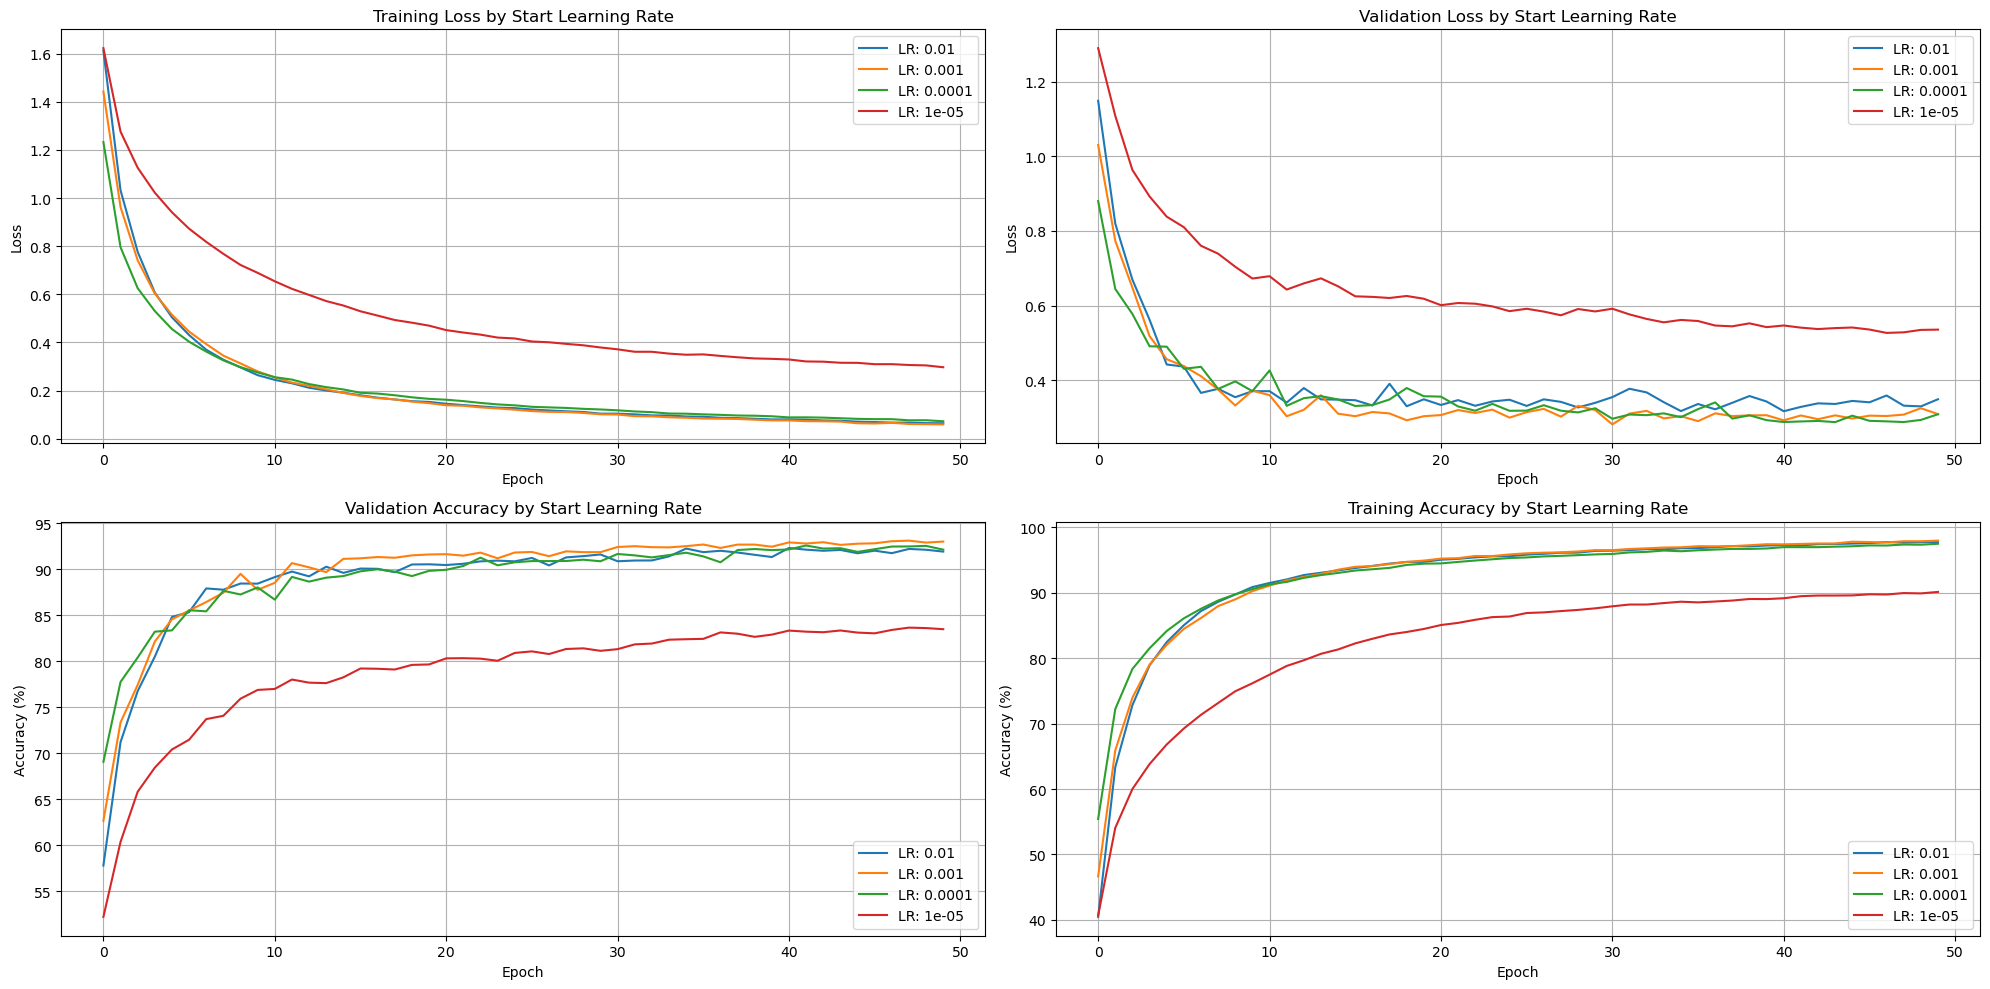

In [12]:
import torch
import matplotlib.pyplot as plt

learning_rates = [0.01, 0.001, 0.0001, 0.00001]

all_metrics_lr = {
    lr: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': [], 'last_lr': []}
    for lr in learning_rates
}




for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    modelResnet3_443 = Resnet3_443().to(device)
    metrics = train_and_evaluate_model(modelResnet3_443, "Resnet3_443", loaders, device, "train_Enhanced", lr, num_epochs=50)
    
    # Unpack returned metrics
    train_loss, valid_loss, valid_accuracy, train_accuracy, last_lr = metrics
    
    # Store metrics in the dictionary
    all_metrics_lr[lr]['train_losses'] = train_loss
    all_metrics_lr[lr]['valid_losses'] = valid_loss
    all_metrics_lr[lr]['valid_accuracies'] = valid_accuracy
    all_metrics_lr[lr]['train_accuracies'] = train_accuracy
    all_metrics_lr[lr]['last_lr'] = last_lr




plt.figure(figsize=(20, 10))

# Plot Training Loss for Each Learning Rate
plt.subplot(2, 2, 1)
for lr, metrics in all_metrics_lr.items():
    plt.plot(metrics['train_losses'], label=f'LR: {lr}')
plt.title('Training Loss by Start Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Validation Loss for Each Learning Rate
plt.subplot(2, 2, 2)
for lr, metrics in all_metrics_lr.items():
    plt.plot(metrics['valid_losses'], label=f'LR: {lr}')
plt.title('Validation Loss by Start Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy for Each Learning Rate
plt.subplot(2, 2, 3)
for lr, metrics in all_metrics_lr.items():
    plt.plot(metrics['valid_accuracies'], label=f'LR: {lr}')
plt.title('Validation Accuracy by Start Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot Training Accuracy for Each Learning Rate
plt.subplot(2, 2, 4)
for lr, metrics in all_metrics_lr.items():
    plt.plot(metrics['train_accuracies'], label=f'LR: {lr}')
plt.title('Training Accuracy by Start Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# Optimizer Test
SGD Momentum 0.9 and weighdecay 0.001, Adam with weightdecay 0.001, Adamw with weightdecay 0.001. 

then best result with weightdecay range [0.01,0.001,0.0001,0.00001]   total 7 runs. 

In [26]:

def train_and_evaluate_model(model, model_name, loaders, device, optimizer_func, loader_key, learning_rate=0.001, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_func(model.parameters(), lr=learning_rate, weight_decay=0.001)
    scheduler = ExponentialLR(optimizer, gamma=0.98)

    # Metrics initialization
    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    
    start_time = time.time()  # Initialize start time here

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders[loader_key]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            num_batches += 1

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders[loader_key]) - 1:
                print(f"LR: {learning_rate}, {model_name}, {loader_key} - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders[loader_key].dataset)} "
                      f"({100. * (i + 1) / len(loaders[loader_key]):.0f}%)]  Loss: {running_loss / num_batches:.4f}")  # Corrected loss reporting
                running_loss, num_batches = 0.0, 0

        avg_train_loss = total_train_loss / num_train_examples  # Correct average training loss calculation
        train_loss_history.append(avg_train_loss)

        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()
            num_valid_batches += 1

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Correct average validation loss calculation
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"StartLR: {learning_rate}, {model_name}, {loader_key} - Epoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), f'{model_name}_{loader_key}_{learning_rate}_best_model.pth')
            print(f"Saved best model for {model_name} with {loader_key} at epoch {epoch}, lr={learning_rate}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"{model_name} with {loader_key}, lr={learning_rate} - Execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history, last_lr




Training with optimizer: AdamW
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [6400/80000 (8%)]  Loss: 1.9591
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [12800/80000 (16%)]  Loss: 1.7247
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [19200/80000 (24%)]  Loss: 1.5907
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [25600/80000 (32%)]  Loss: 1.4827
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [32000/80000 (40%)]  Loss: 1.3837
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [38400/80000 (48%)]  Loss: 1.3172
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [44800/80000 (56%)]  Loss: 1.2838
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [51200/80000 (64%)]  Loss: 1.2176
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [57600/80000 (72%)]  Loss: 1.1786
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [64000/80000 (80%)]  Loss: 1.1579
LR: 0.001, Resnet3_443, train_Enhanced - Epoch: 1 [70400/80000 (88%)]  Loss: 1.0866
LR: 0.001, Resnet3_443, train_Enhanced - Epoch:

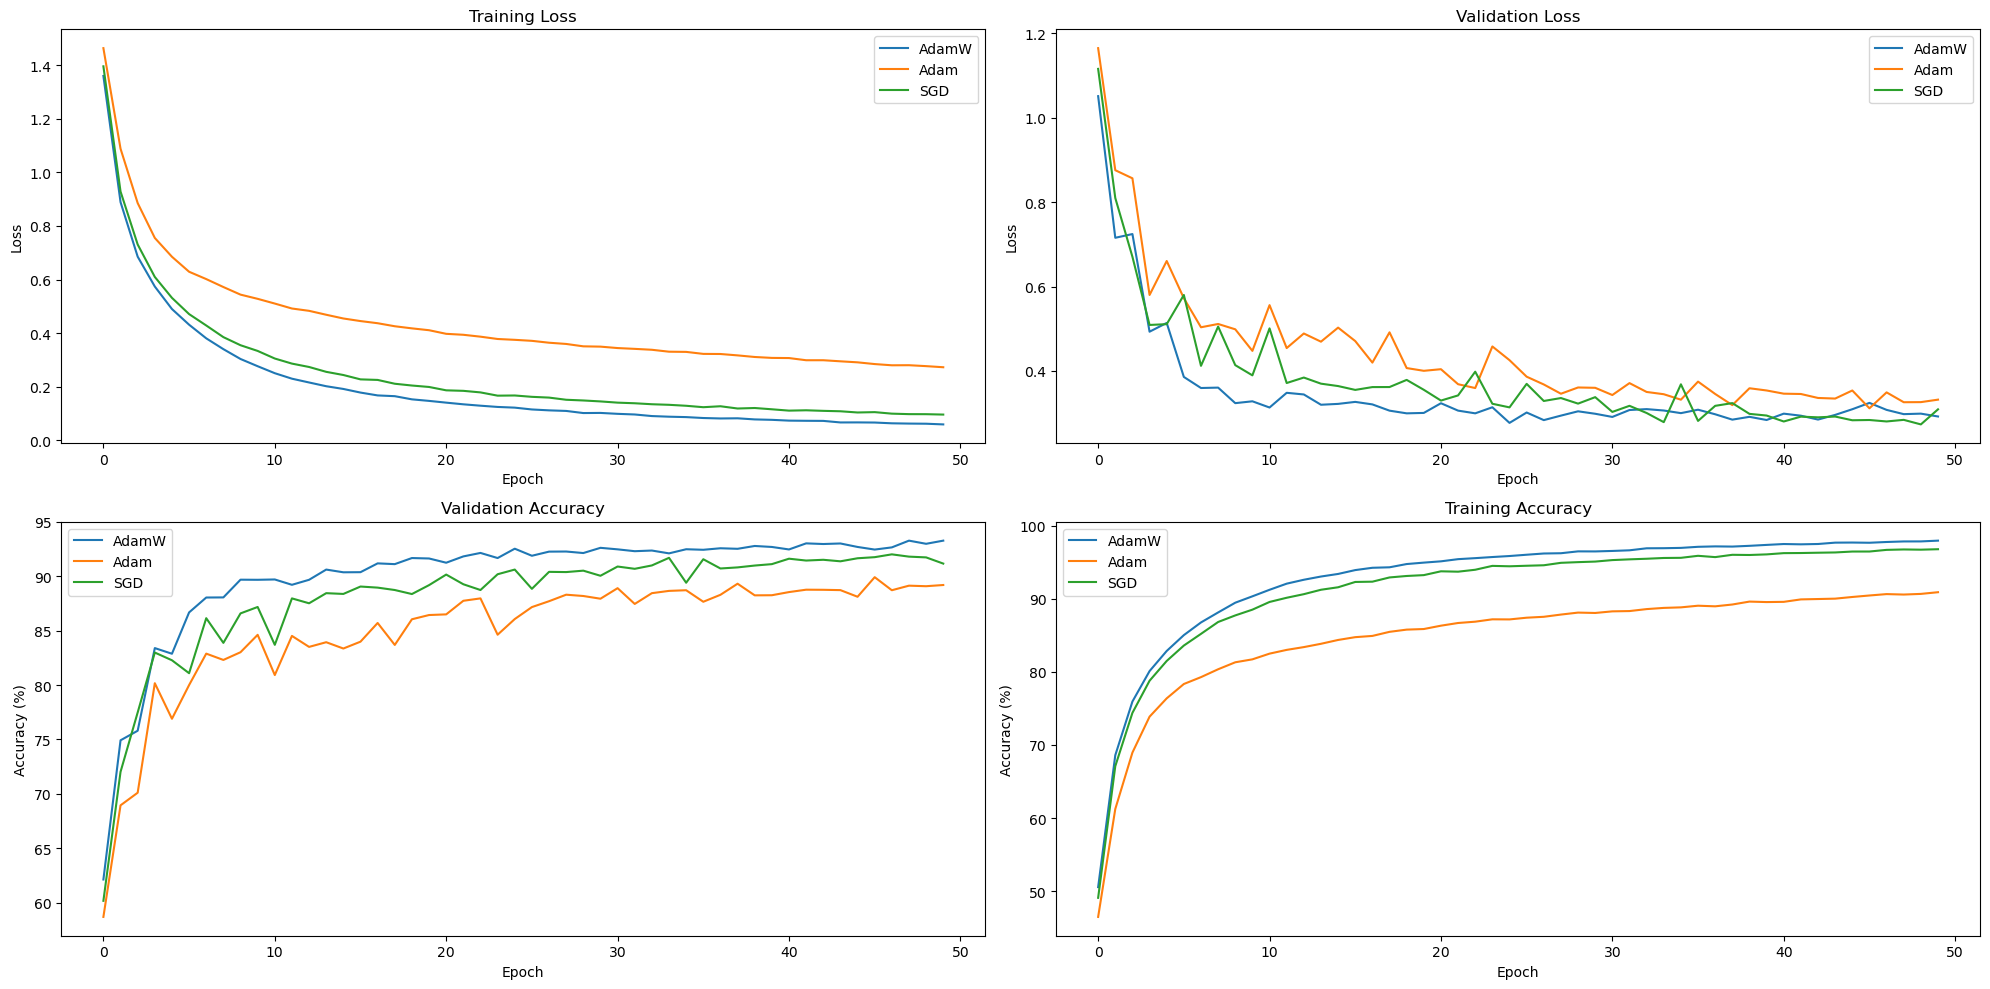

In [27]:
# Define your optimizer setup outside the function to avoid using model before definition
optimizer_methods = {
    'AdamW': optim.AdamW,
    'Adam': optim.Adam,
    'SGD': lambda params, lr, weight_decay: optim.SGD(params, lr=lr, weight_decay=weight_decay, momentum=0.9)
}

all_metrics_optim = {name: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': [], 'last_lr': []} for name in optimizer_methods.keys()}

for optimizer_name, optimizer_func in optimizer_methods.items():
    print(f"Training with optimizer: {optimizer_name}")
    model = Resnet3_443().to(device)
    # Since the optimizer_func is expected to be a factory function, 
    # we pass it directly without instantiation here
    metrics = train_and_evaluate_model(model, "Resnet3_443", loaders, device, optimizer_func, "train_Enhanced", 0.001, 50)
    
    # Assuming metrics are unpacked correctly from the function
    all_metrics_optim[optimizer_name]['train_losses'], \
    all_metrics_optim[optimizer_name]['valid_losses'], \
    all_metrics_optim[optimizer_name]['valid_accuracies'], \
    all_metrics_optim[optimizer_name]['train_accuracies'], \
    all_metrics_optim[optimizer_name]['last_lr'] = metrics


plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for name, metrics in all_metrics_optim.items():
    plt.plot(metrics['train_losses'], label=name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for name, metrics in all_metrics_optim.items():
    plt.plot(metrics['valid_losses'], label=name)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
for name, metrics in all_metrics_optim.items():
    plt.plot(metrics['valid_accuracies'], label=name)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for name, metrics in all_metrics_optim.items():
    plt.plot(metrics['train_accuracies'], label=name)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Best performance: Resnet 3 443, Enhanced Training Dataset, LR at 0.001, AdamW 

In [23]:
all_metrics_optim

{'AdamW': {'train_losses': 'train_losses',
  'valid_losses': 'valid_losses',
  'valid_accuracies': 'valid_accuracies',
  'train_accuracies': 'train_accuracies',
  'last_lr': 'last_lr'},
 'Adam': {'train_losses': 'train_losses',
  'valid_losses': 'valid_losses',
  'valid_accuracies': 'valid_accuracies',
  'train_accuracies': 'train_accuracies',
  'last_lr': 'last_lr'},
 'SGD': {'train_losses': 'train_losses',
  'valid_losses': 'valid_losses',
  'valid_accuracies': 'valid_accuracies',
  'train_accuracies': 'train_accuracies',
  'last_lr': 'last_lr'}}

# Weight Decay Test

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import time

def train_and_evaluate_model(model, model_name, loaders, device, weight_decay, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)
    scheduler = ExponentialLR(optimizer, gamma=0.98)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders["train_Enhanced"]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)
            num_batches += 1

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders["train_Enhanced"]) - 1:
                print(f"{model_name}, train_Enhanced - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders['train_Enhanced'].dataset)} "
                      f"({100. * (i + 1) / len(loaders['train_Enhanced']):.0f}%)], Weight Decay: {weight_decay},  Loss: {running_loss / num_batches:.4f}")

        avg_train_loss = total_train_loss / num_train_examples  # Correct average training loss calculation
        train_loss_history.append(avg_train_loss)

        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()
            num_valid_batches += 1

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Correct average validation loss calculation
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"End of Epoch: {epoch}, Avg. Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            model_path = f'{model_name}_weight_decay_{weight_decay}_best_model.pth'
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved: {model_path}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"Training completed. Total execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history


Training with weight decay: 0.01
Resnet3_443, train_Enhanced - Epoch: 1 [6400/80000 (8%)], Weight Decay: 0.01,  Loss: 1.9639
Resnet3_443, train_Enhanced - Epoch: 1 [12800/80000 (16%)], Weight Decay: 0.01,  Loss: 1.8499
Resnet3_443, train_Enhanced - Epoch: 1 [19200/80000 (24%)], Weight Decay: 0.01,  Loss: 1.7933
Resnet3_443, train_Enhanced - Epoch: 1 [25600/80000 (32%)], Weight Decay: 0.01,  Loss: 1.7365
Resnet3_443, train_Enhanced - Epoch: 1 [32000/80000 (40%)], Weight Decay: 0.01,  Loss: 1.6903
Resnet3_443, train_Enhanced - Epoch: 1 [38400/80000 (48%)], Weight Decay: 0.01,  Loss: 1.6451
Resnet3_443, train_Enhanced - Epoch: 1 [44800/80000 (56%)], Weight Decay: 0.01,  Loss: 1.6033
Resnet3_443, train_Enhanced - Epoch: 1 [51200/80000 (64%)], Weight Decay: 0.01,  Loss: 1.5649
Resnet3_443, train_Enhanced - Epoch: 1 [57600/80000 (72%)], Weight Decay: 0.01,  Loss: 1.5316
Resnet3_443, train_Enhanced - Epoch: 1 [64000/80000 (80%)], Weight Decay: 0.01,  Loss: 1.4980
Resnet3_443, train_Enhanced -

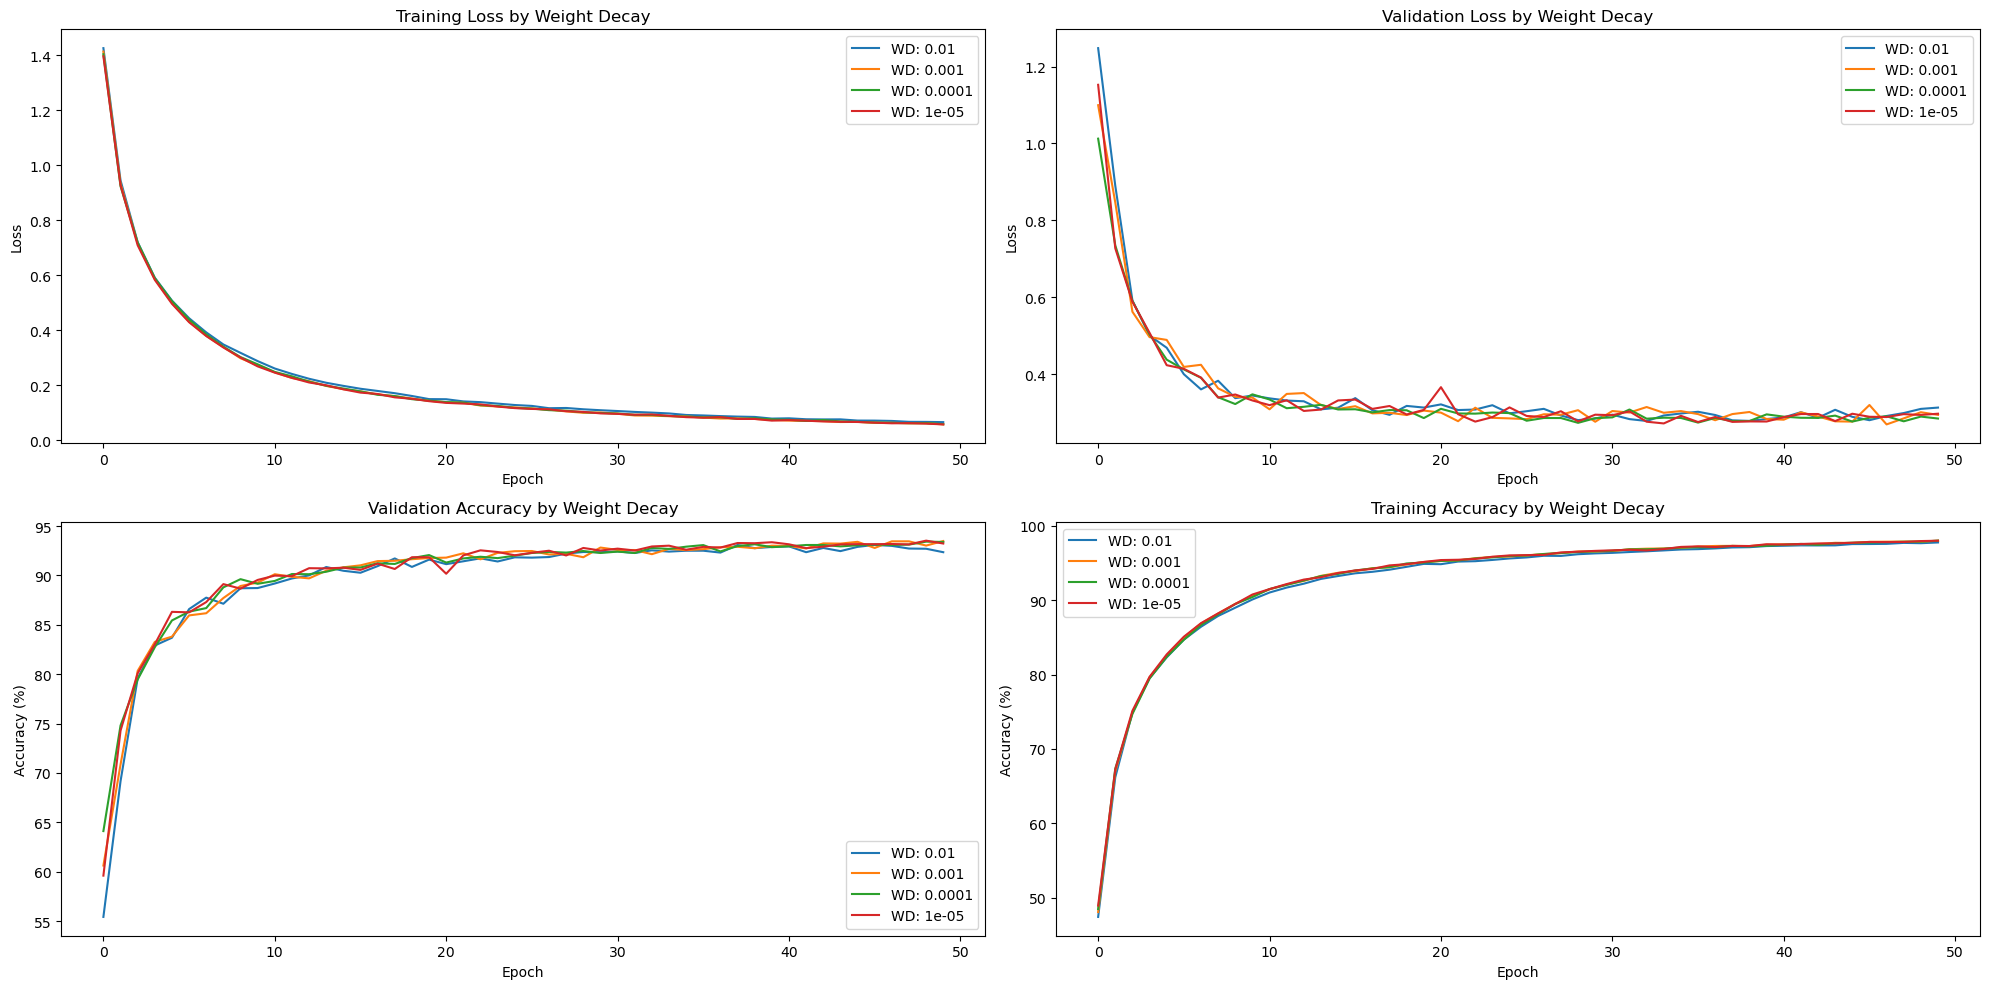

In [35]:
import torch
from torch.optim import AdamW
import matplotlib.pyplot as plt

# Assuming Resnet3_443 is defined and device is set
model = Resnet3_443().to(device)
weight_decays = [0.01, 0.001, 0.0001, 0.00001]
num_epochs = 50  # Or any other number of epochs you want to train for

all_metrics_weight_decay = {
    wd: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
    for wd in weight_decays
}

for weight_decay in weight_decays:
    print(f"Training with weight decay: {weight_decay}")
    # Re-initialize the model for each weight decay to ensure training starts fresh
    model = Resnet3_443().to(device)
    metrics = train_and_evaluate_model(model, "Resnet3_443", loaders, device, weight_decay, num_epochs)
    
    # Unpack and store the returned metrics
    all_metrics_weight_decay[weight_decay]['train_losses'], \
    all_metrics_weight_decay[weight_decay]['valid_losses'], \
    all_metrics_weight_decay[weight_decay]['valid_accuracies'], \
    all_metrics_weight_decay[weight_decay]['train_accuracies'] = metrics

# Plotting
plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['train_losses'], label=f'WD: {wd}')
plt.title('Training Loss by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['valid_losses'], label=f'WD: {wd}')
plt.title('Validation Loss by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['valid_accuracies'], label=f'WD: {wd}')
plt.title('Validation Accuracy by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for wd, metrics in all_metrics_weight_decay.items():
    plt.plot(metrics['train_accuracies'], label=f'WD: {wd}')
plt.title('Training Accuracy by Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Best Performance: Resnet3 443, Enhanced Training Dataset, LR = 0.001, AdamW(Weightdecay=0.0001) 

# Gradient Clipping Test

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import time

def train_and_evaluate_model(model, model_name, loaders, device, grad_clip_values, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.00001)
    scheduler = ExponentialLR(optimizer, gamma=0.98)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders["train_Enhanced"]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_values)
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)
            num_batches += 1

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders["train_Enhanced"]) - 1:
                print(f"{model_name}, train_Enhanced - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders['train_Enhanced'].dataset)} "
                      f"({100. * (i + 1) / len(loaders['train_Enhanced']):.0f}%)], gradientclip: {grad_clip_values}  Loss: {running_loss / num_batches:.4f}")

        avg_train_loss = total_train_loss / num_train_examples  # Correct average training loss calculation
        train_loss_history.append(avg_train_loss)

        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()
            num_valid_batches += 1

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Correct average validation loss calculation
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"End of Epoch: {epoch}, Avg. Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            model_path = f'{model_name}_GradClip_{grad_clip_values}_best_model.pth'
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved: {model_path}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"Training completed. Total execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history


Training with gradient clipping: 5.0
Resnet3_443, train_Enhanced - Epoch: 1 [6400/80000 (8%)], gradientclip: 5.0  Loss: 1.9755
Resnet3_443, train_Enhanced - Epoch: 1 [12800/80000 (16%)], gradientclip: 5.0  Loss: 1.8270
Resnet3_443, train_Enhanced - Epoch: 1 [19200/80000 (24%)], gradientclip: 5.0  Loss: 1.7455
Resnet3_443, train_Enhanced - Epoch: 1 [25600/80000 (32%)], gradientclip: 5.0  Loss: 1.6801
Resnet3_443, train_Enhanced - Epoch: 1 [32000/80000 (40%)], gradientclip: 5.0  Loss: 1.6263
Resnet3_443, train_Enhanced - Epoch: 1 [38400/80000 (48%)], gradientclip: 5.0  Loss: 1.5767
Resnet3_443, train_Enhanced - Epoch: 1 [44800/80000 (56%)], gradientclip: 5.0  Loss: 1.5364
Resnet3_443, train_Enhanced - Epoch: 1 [51200/80000 (64%)], gradientclip: 5.0  Loss: 1.4967
Resnet3_443, train_Enhanced - Epoch: 1 [57600/80000 (72%)], gradientclip: 5.0  Loss: 1.4639
Resnet3_443, train_Enhanced - Epoch: 1 [64000/80000 (80%)], gradientclip: 5.0  Loss: 1.4323
Resnet3_443, train_Enhanced - Epoch: 1 [70400

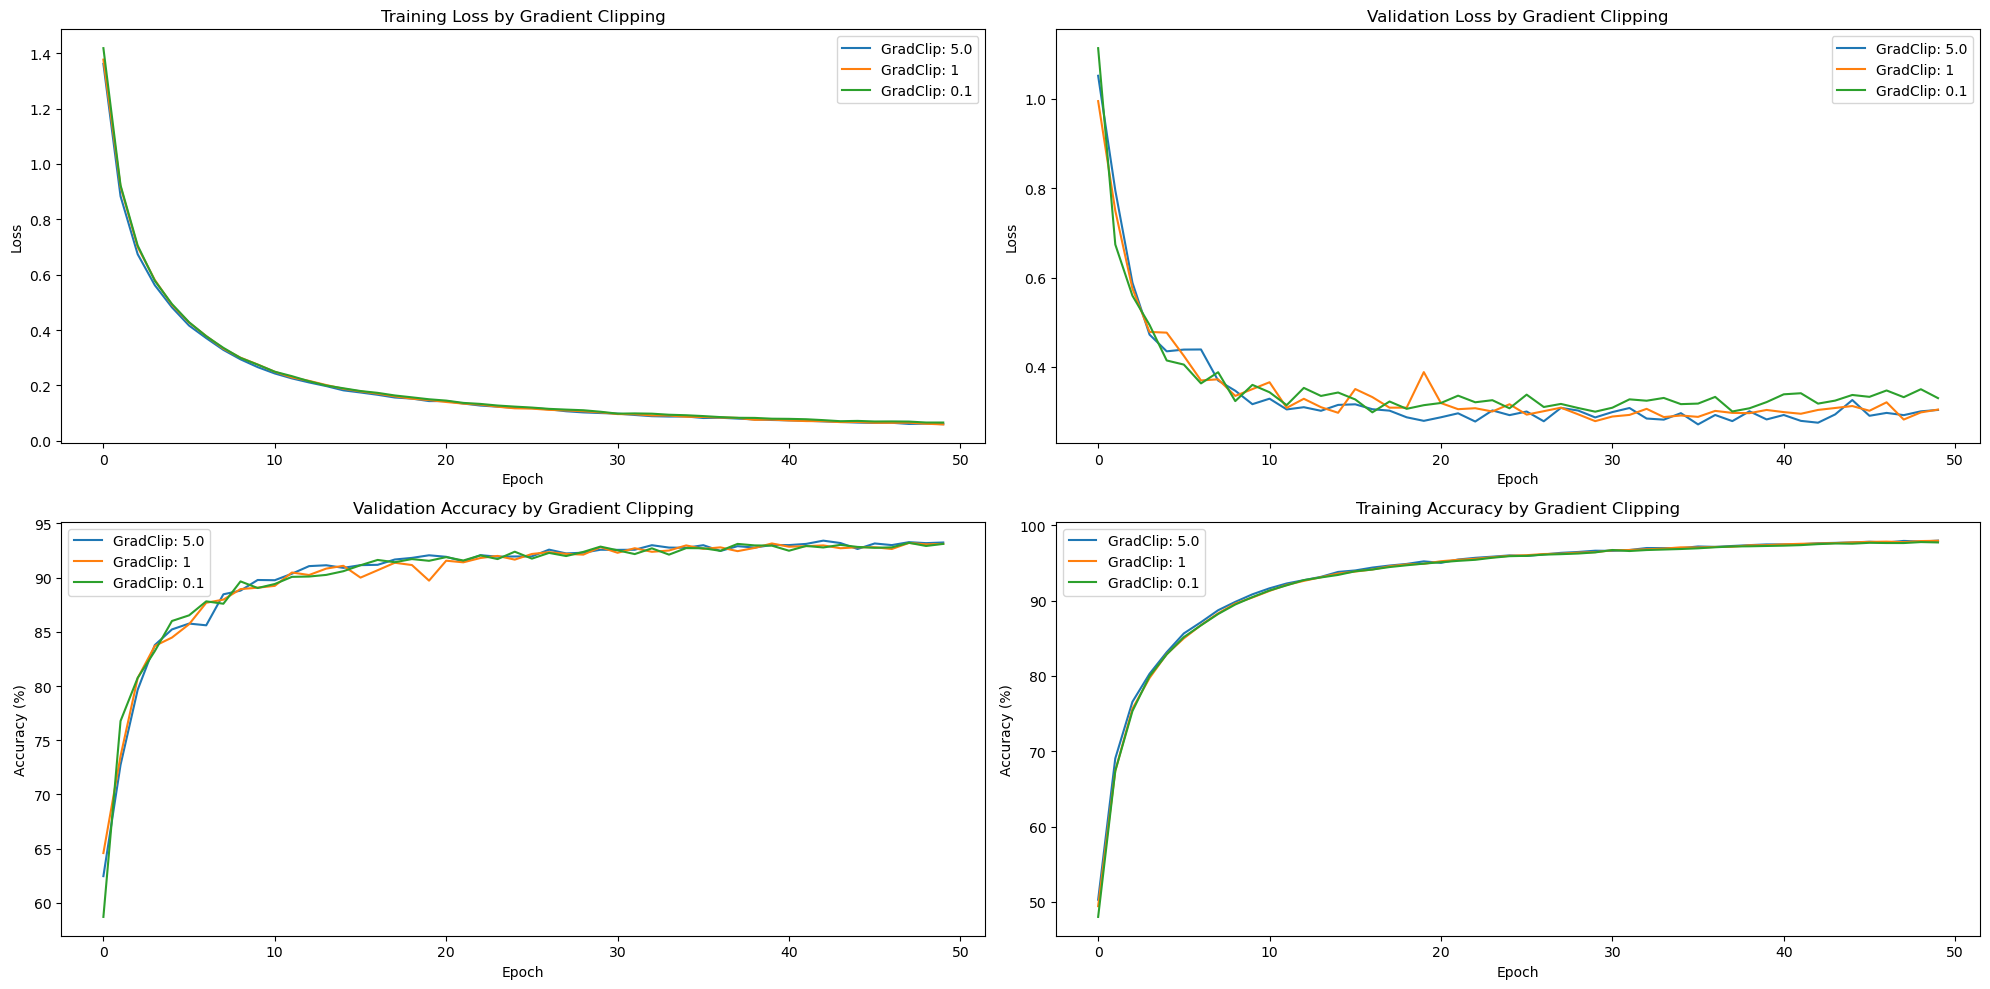

In [43]:
import torch
from torch.optim import AdamW
import matplotlib.pyplot as plt

# Assuming Resnet3_443 is defined and device is set
model = Resnet3_443().to(device)
gradClip = [5.0, 1, 0.1]
num_epochs = 50  # Or any other number of epochs you want to train for

all_metrics_gradClip = {
    gc: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
    for gc in gradClip
}

# Corrected loop and model saving
for grad_clip_value in gradClip:
    print(f"Training with gradient clipping: {grad_clip_value}")
    # Re-initialize the model for each gradient clipping value to ensure training starts fresh
    model = Resnet3_443().to(device)  # Make sure Resnet3_443 is defined or replace with your model initialization
    metrics = train_and_evaluate_model(model, "Resnet3_443", loaders, device, grad_clip_value, num_epochs)
    
    # Unpack and store the returned metrics
    all_metrics_gradClip[grad_clip_value]['train_losses'], \
    all_metrics_gradClip[grad_clip_value]['valid_losses'], \
    all_metrics_gradClip[grad_clip_value]['valid_accuracies'], \
    all_metrics_gradClip[grad_clip_value]['train_accuracies'] = metrics

# Plotting
plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for gc, metrics in all_metrics_gradClip.items():
    plt.plot(metrics['train_losses'], label=f'GradClip: {gc}')
plt.title('Training Loss by Gradient Clipping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for gc, metrics in all_metrics_gradClip.items():
    plt.plot(metrics['valid_losses'], label=f'GradClip: {gc}')
plt.title('Validation Loss by Gradient Clipping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
for gc, metrics in all_metrics_gradClip.items():
    plt.plot(metrics['valid_accuracies'], label=f'GradClip: {gc}')
plt.title('Validation Accuracy by Gradient Clipping')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for gc, metrics in all_metrics_gradClip.items():
    plt.plot(metrics['train_accuracies'], label=f'GradClip: {gc}')
plt.title('Training Accuracy by Gradient Clipping')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


decision: gradclip of 0.1

# Learning Rate Scheduler Test



In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import time

def train_and_evaluate_model(model, model_name, loaders, device, scheduler_factory,scheduler_name, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.00001)
    scheduler = scheduler_factory(optimizer)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders["train_Enhanced"]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)
            num_batches += 1

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders["train_Enhanced"]) - 1:
                print(f"{model_name}, train_Enhanced - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders['train_Enhanced'].dataset)} "
                      f"({100. * (i + 1) / len(loaders['train_Enhanced']):.0f}%)]  Loss: {running_loss / num_batches:.4f}")

        avg_train_loss = total_train_loss / num_train_examples  # Correct average training loss calculation
        train_loss_history.append(avg_train_loss)

        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()
            num_valid_batches += 1

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Correct average validation loss calculation
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"End of Epoch: {epoch}, Avg. Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            model_path = f'{model_name}_{scheduler_name}_best_model.pth'
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved: {model_path}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"Training completed. Total execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history


Training with scheduler: NoScheduler
Resnet3_443, train_Enhanced - Epoch: 1 [6400/80000 (8%)]  Loss: 1.9998
Resnet3_443, train_Enhanced - Epoch: 1 [12800/80000 (16%)]  Loss: 1.8720
Resnet3_443, train_Enhanced - Epoch: 1 [19200/80000 (24%)]  Loss: 1.7943
Resnet3_443, train_Enhanced - Epoch: 1 [25600/80000 (32%)]  Loss: 1.7352
Resnet3_443, train_Enhanced - Epoch: 1 [32000/80000 (40%)]  Loss: 1.6867
Resnet3_443, train_Enhanced - Epoch: 1 [38400/80000 (48%)]  Loss: 1.6448
Resnet3_443, train_Enhanced - Epoch: 1 [44800/80000 (56%)]  Loss: 1.6042
Resnet3_443, train_Enhanced - Epoch: 1 [51200/80000 (64%)]  Loss: 1.5704
Resnet3_443, train_Enhanced - Epoch: 1 [57600/80000 (72%)]  Loss: 1.5364
Resnet3_443, train_Enhanced - Epoch: 1 [64000/80000 (80%)]  Loss: 1.5040
Resnet3_443, train_Enhanced - Epoch: 1 [70400/80000 (88%)]  Loss: 1.4744
Resnet3_443, train_Enhanced - Epoch: 1 [76800/80000 (96%)]  Loss: 1.4449
Resnet3_443, train_Enhanced - Epoch: 1 [80000/80000 (100%)]  Loss: 1.4312
End of Epoch: 1

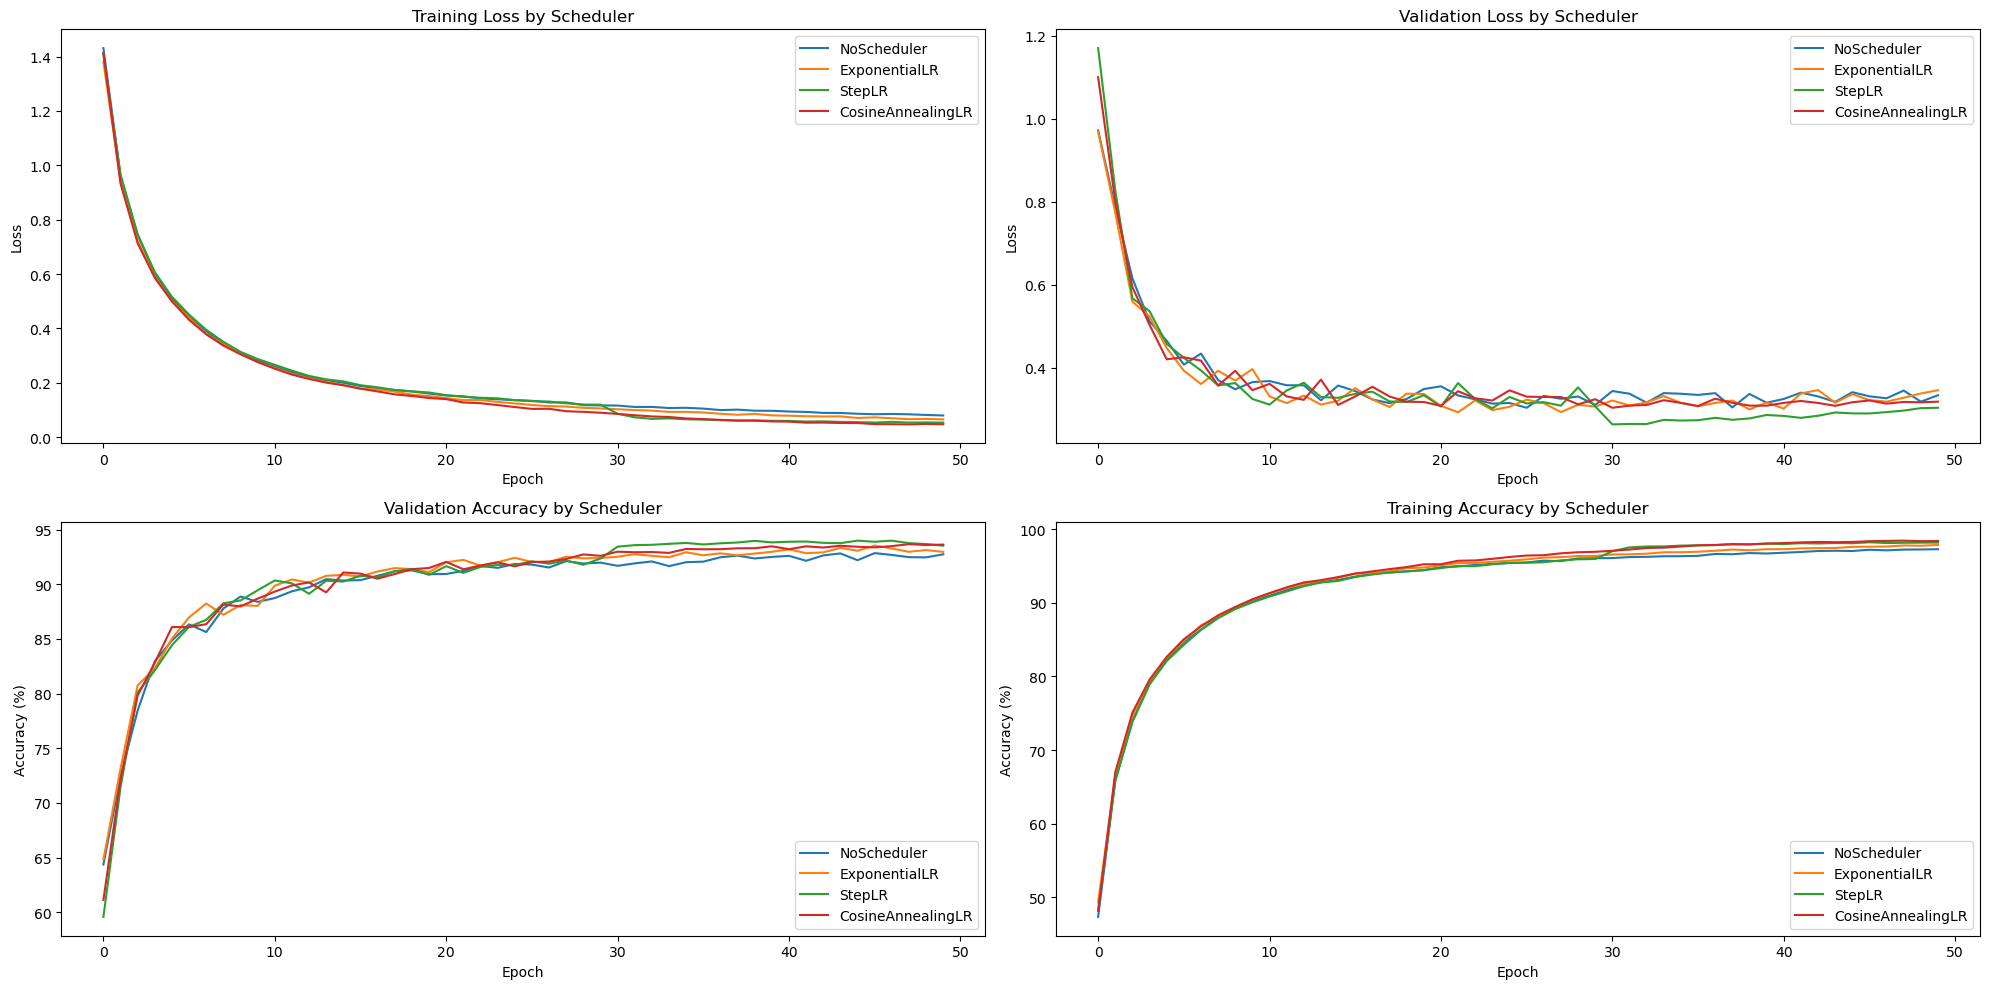

In [61]:
import matplotlib.pyplot as plt

model = Resnet3_443().to(device)

def no_op_scheduler(optimizer):
    """Returns a LambdaLR scheduler that does nothing."""
    return LambdaLR(optimizer, lr_lambda=lambda epoch: 1)

# Define scheduler factories
def exp_lr_scheduler(optimizer):
    return ExponentialLR(optimizer, gamma=0.98)

def step_lr_scheduler(optimizer):
    return StepLR(optimizer, step_size=30, gamma=0.1)

def cosine_annealing_scheduler(optimizer):
    return CosineAnnealingLR(optimizer, T_max=50)



scheduler_factories = {
    'NoScheduler': no_op_scheduler, 
    'ExponentialLR': exp_lr_scheduler,
    'StepLR': step_lr_scheduler,
    'CosineAnnealingLR': cosine_annealing_scheduler
     # Added 'NoScheduler' for the flat learning rate case
}

num_epochs = 50  # Adjust as needed

all_metrics_schedulers = {
    name: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
    for name in scheduler_factories.keys()
}

for name, scheduler_factory in scheduler_factories.items():
    print(f"Training with scheduler: {name}")
    # Re-initialize the model for each scheduler to ensure training starts fresh
    model = Resnet3_443().to(device)
    metrics = train_and_evaluate_model(model, "Resnet3_443", loaders, device, scheduler_factory, name, num_epochs=num_epochs)  # Adjusted to include the scheduler name in the model name
    
    # Unpack and store the returned metrics
    all_metrics_schedulers[name]['train_losses'], \
    all_metrics_schedulers[name]['valid_losses'], \
    all_metrics_schedulers[name]['valid_accuracies'], \
    all_metrics_schedulers[name]['train_accuracies'] = metrics

# Plotting
plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for name, metrics in all_metrics_schedulers.items():
    plt.plot(metrics['train_losses'], label=name)
plt.title('Training Loss by Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for name, metrics in all_metrics_schedulers.items():
    plt.plot(metrics['valid_losses'], label=name)
plt.title('Validation Loss by Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
for name, metrics in all_metrics_schedulers.items():
    plt.plot(metrics['valid_accuracies'], label=name)
plt.title('Validation Accuracy by Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for name, metrics in all_metrics_schedulers.items():
    plt.plot(metrics['train_accuracies'], label=name)
plt.title('Training Accuracy by Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


decision: StepLR 30 stepsize, gamma 0.1

# Dropouts
Dropout is applied before final linear layer in the Model Architecture. 

In [10]:
def train_and_evaluate_model(model, model_name, loaders, device, num_epochs=50):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders["train_Enhanced"]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels =labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)  # Correct loss accumulation
            num_batches += 1

            pred = outputs.argmax(dim=1)
            total_correct_train += (pred == labels).sum().item()
            num_train_examples += labels.size(0)
            if (i + 1) % 100 == 0 or i == len(loaders['train_Enhanced']) - 1:
                print(f"{model_name}, train_Enhanced - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders['train_Enhanced'].dataset)} "
                     f"({100. * (i + 1) / len(loaders['train_Enhanced']):.0f}%)]  Loss: {running_loss / num_batches:.4f}")  # Corrected loss reporting
                running_loss, num_batches = 0.0, 0
        avg_train_loss = total_train_loss / num_train_examples  # Corrected average training loss
        train_loss_history.append(avg_train_loss)

        train_accuracy = (total_correct_train / num_train_examples) * 100  # Calculate training accuracy
        train_accuracy_history.append(train_accuracy)  # Store training accuracy per epoch

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Correct loss accumulation
            pred = outputs.argmax(dim=1)
            total_correct_valid += (pred == labels).sum().item()

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Corrected average validation loss
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = (total_correct_valid / len(loaders['valid'].dataset)) * 100  # Calculate validation accuracy
        valid_accuracy_history.append(valid_accuracy)  # Store validation accuracy per epoch

        print(f"{model_name} - Epoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            print(f"Saved best model for {model_name} at epoch {epoch}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"{model_name} - Execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history


Total parameters modelResnet3_443_0DR: 4697162
Total parameters modelResnet3_443_20DR: 4697162
Total parameters modelResnet3_443_30DR: 4697162
Total parameters modelResnet3_443_50DR: 4697162
NVIDIA GeForce RTX 4070
Training modelResnet3_443_0DR
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [6400/80000 (8%)]  Loss: 1.9497
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [12800/80000 (16%)]  Loss: 1.7207
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [19200/80000 (24%)]  Loss: 1.5689
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [25600/80000 (32%)]  Loss: 1.4765
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [32000/80000 (40%)]  Loss: 1.3974
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [38400/80000 (48%)]  Loss: 1.3586
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [44800/80000 (56%)]  Loss: 1.2882
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [51200/80000 (64%)]  Loss: 1.1840
modelResnet3_443_0DR, train_Enhanced - Epoch: 1 [57600/80000 (72%)]  Loss: 1.1768
modelResnet3_443_0D

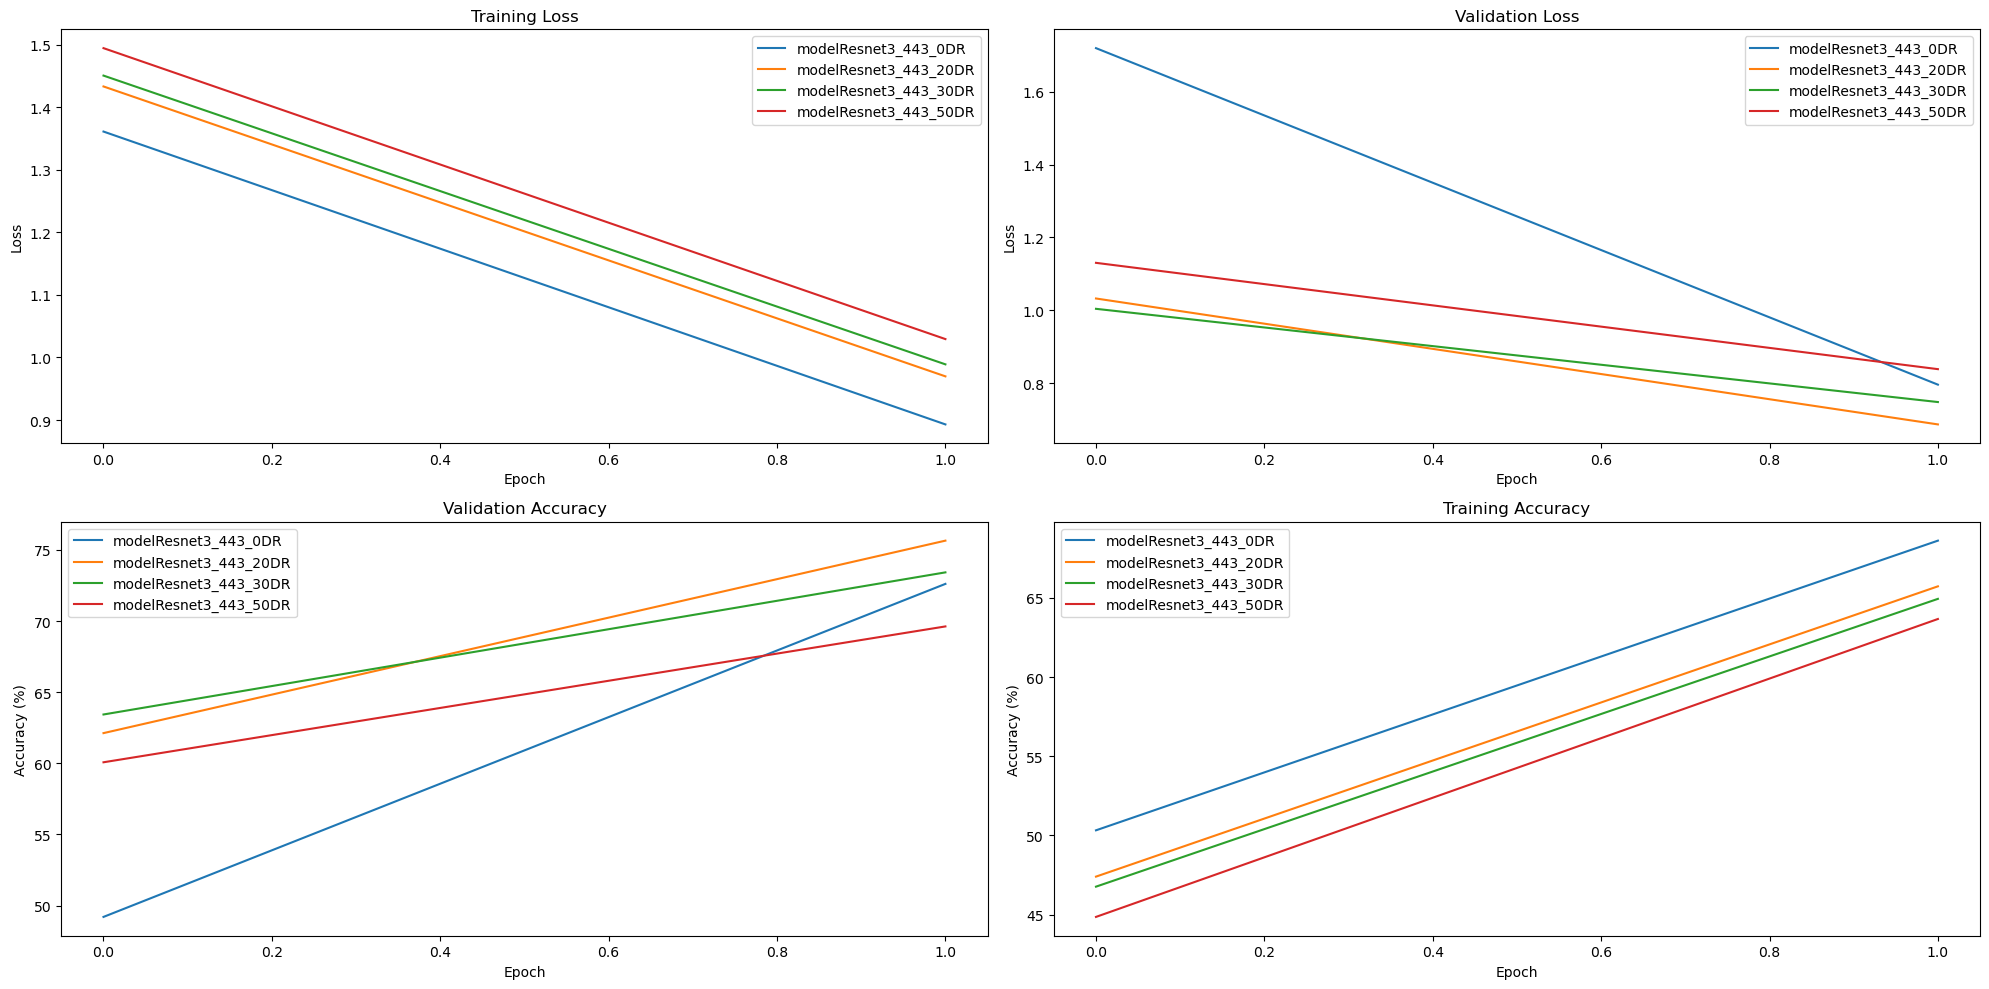

In [11]:
#----------  0 Dropout
def ResNet3_with_dropout_0DR():
    return ResNet3Dropouts(BasicBlockDropouts, [4, 4, 3], dropout_rate=0)  # For example, a dropout rate of 0.5
modelResnet3_443_0DR = ResNet3_with_dropout_0DR()
total_paramsResnet3_443_0DR = sum(p.numel() for p in modelResnet3_443_0DR.parameters())
print(f"Total parameters modelResnet3_443_0DR: {total_paramsResnet3_443_0DR}")
#------- 0.2 Dropout
def ResNet3_with_dropout_20DR():
    return ResNet3Dropouts(BasicBlockDropouts, [4, 4, 3], dropout_rate=0.2)  # For example, a dropout rate of 0.5
modelResnet3_443_20DR = ResNet3_with_dropout_20DR()
total_paramsResnet3_443_20DR = sum(p.numel() for p in modelResnet3_443_20DR.parameters())
print(f"Total parameters modelResnet3_443_20DR: {total_paramsResnet3_443_20DR}")
#--------- 0.3 Dropout
def ResNet3_with_dropout_30DR():
    return ResNet3Dropouts(BasicBlockDropouts, [4, 4, 3], dropout_rate=0.3)  # For example, a dropout rate of 0.5
modelResnet3_443_30DR = ResNet3_with_dropout_30DR()
total_paramsResnet3_443_30DR = sum(p.numel() for p in modelResnet3_443_30DR.parameters())
print(f"Total parameters modelResnet3_443_30DR: {total_paramsResnet3_443_30DR}")
#----- 0.5 Dropout
def ResNet3_with_dropout_50DR():
    return ResNet3Dropouts(BasicBlockDropouts, [4, 4, 3], dropout_rate=0.5)  # For example, a dropout rate of 0.5
modelResnet3_443_50DR = ResNet3_with_dropout_50DR()
total_paramsmodelResnet3_443_50DR = sum(p.numel() for p in modelResnet3_443_50DR.parameters())
print(f"Total parameters modelResnet3_443_50DR: {total_paramsmodelResnet3_443_50DR}")


# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

#--------- training call

model_names = ['modelResnet3_443_0DR', 'modelResnet3_443_20DR', 'modelResnet3_443_30DR', 'modelResnet3_443_50DR']
models = [modelResnet3_443_0DR, modelResnet3_443_20DR, modelResnet3_443_30DR, modelResnet3_443_50DR]

# Initialize dictionaries to store the metrics
all_metrics_Dropouts = {
    model_name: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
    for model_name in model_names
}


num_epochs=50

# Train and evaluate each model
for model, model_name in zip(models, model_names):
    model.to(device)
    print(f"Training {model_name}")
    train_loss, valid_loss, valid_accuracy, train_accuracy = train_and_evaluate_model(model, model_name, loaders, device, num_epochs=num_epochs)
    
    # Store metrics in the dictionary
    all_metrics_Dropouts[model_name]['train_losses'] = train_loss
    all_metrics_Dropouts[model_name]['valid_losses'] = valid_loss
    all_metrics_Dropouts[model_name]['valid_accuracies'] = valid_accuracy
    all_metrics_Dropouts[model_name]['train_accuracies'] = train_accuracy


plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for name, metrics in all_metrics_Dropouts.items():
    plt.plot(metrics['train_losses'], label=name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for name, metrics in all_metrics_Dropouts.items():
    plt.plot(metrics['valid_losses'], label=name)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
for name, metrics in all_metrics_Dropouts.items():
    plt.plot(metrics['valid_accuracies'], label=name)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for name, metrics in all_metrics_Dropouts.items():
    plt.plot(metrics['train_accuracies'], label=name)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


# Dropouts 